# ACE_krill dataset Data Jam Days

This code has been made by Benjamin Ricaud (benjamin.ricaud@gmail.com) and Camille Le Guen (cmmalg@st-andrews.ac.uk) during the Data Jam Days at EPFL on the 24th and 25th November 2017.
The code is under the MIT license (see bottom of the page).

## Data description

Data collected during the Antarctic Circumnavigation Expedition (ACE) in 2017 using an EK80 echosounder running at a frequency of 200 kHz.

## Objective

Detect the presence of krill aggregations in the water column along the ship track.

## Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.signal
import skimage

## Import data



We import the csv file.

In [4]:
data_path = '/home/benjamin/Documents/datascience/data jam days/Hackathlon data/'
df = pd.read_csv(data_path+'ACE_leg2_200khz-D20170214-T025444.sv.csv')

We are interested in the  Ping_index , Ping_date , Ping_time , Latitude,  Longitude , and the sv* columns.
Each sv* column corresponds to a depth range.
The Sv* values form what we call an echogram (a group of pixels which forms an echosounder image).
The value for each cell is the logarithm of the intensity of the echo(ratio of the backscattered and the incident intensities).

In [5]:
del df['Distance_gps']
del df['Distance_vl']
del df['Ping_milliseconds']
del df['Depth_start']
del df['Depth_stop']
del df['Range_start']
del df['Range_stop']
del df['Sample_count']

We then extract the echoogram data (separate the Sv* values from the metadata) and rotate the matrix to have the real orientation.

In [6]:
data= np.array(df.iloc[:,5:]).transpose()

The function data.shape gives us the size of the matrix (or echogram).

In [7]:
data.shape

(2688, 9159)

## Filtering processes

The relevant data values for the krill are between -70 and -65

In [8]:
data2 =data.copy()
data2[data<-70] = -70
data2[data>-65] = -65
data2 = data2 + 70

We then apply a filter to remove the interferences, or sonar artifacts (Python script developped by Roland Proud). The methods detects peaks in intensity over a single ping and remove the strong signal for this single column.The definition of the function is given below.
And we added a median filtering, typically used in image processing, to get rid of the surface (residual) noise due to the air bubbles induced by the ship turbines.

In [9]:
def binary_impulse(Sv, threshold=10):
    '''
    :param Sv: gridded Sv values (dB re 1m^-1)
    :type  Sv: numpy.array
    :param threshold: threshold-value (dB re 1m^-1)
    :type  threshold: float
    return:
    :param mask: binary mask (0 - noise; 1 - signal)
    :type  mask: 2D numpy.array
    desc: generate threshold mask    
    '''
    mask = np.ones(Sv.shape).astype(int)
    samples,pings = Sv.shape
    for sample in range(1, samples-1):
        for ping in range(0, pings):
            a = Sv[sample-1, ping]
            b = Sv[sample, ping]
            c = Sv[sample+1, ping]
            if (b - a > threshold) & (b - c > threshold):
                mask[sample, ping] = 0
    return mask

In [10]:
datafilt = binary_impulse(data2.transpose(), threshold=2)
datafilt = datafilt.transpose()*data2
datafilt2 = sp.signal.medfilt(datafilt,kernel_size=3)

### Visualisation of the results of the first filtering processes

<IPython.core.display.Javascript object>


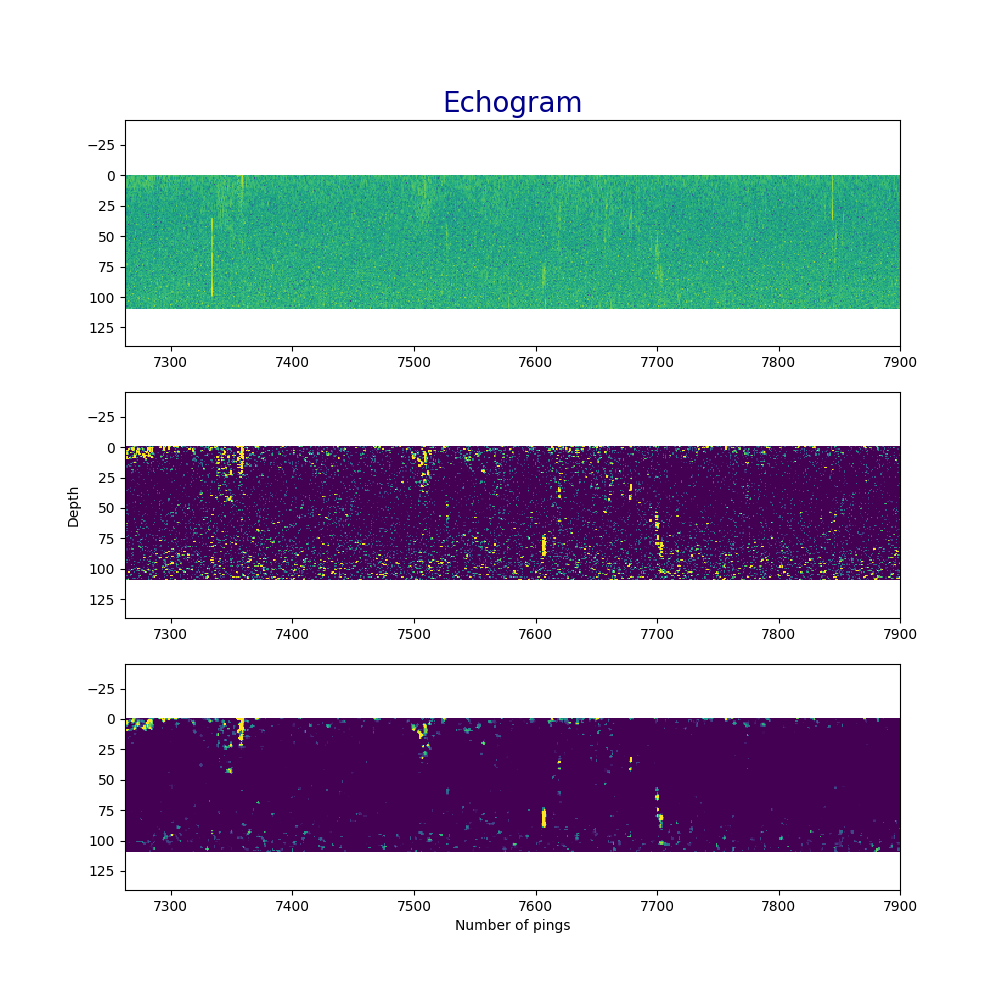

In [11]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10)) 
ax1 = plt.subplot(3,1,1)
ax1.imshow(data[40:150,:])
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(datafilt[40:150,:])
plt.ylabel('Depth')
ax3 = plt.subplot(3,1,3, sharex=ax1, sharey=ax1)
ax3.imshow(datafilt2[40:150,:])
plt.xlabel('Number of pings')
plt.show()

We then try to get rid of the remaining background noise by substracting the mean of each line line to every pixel (smoothing).

In [10]:
data3 =datafilt2.copy()
data3 = data3 - np.mean(data3,1,keepdims=True)

### Visualisation of the results of the second filtering process

<IPython.core.display.Javascript object>


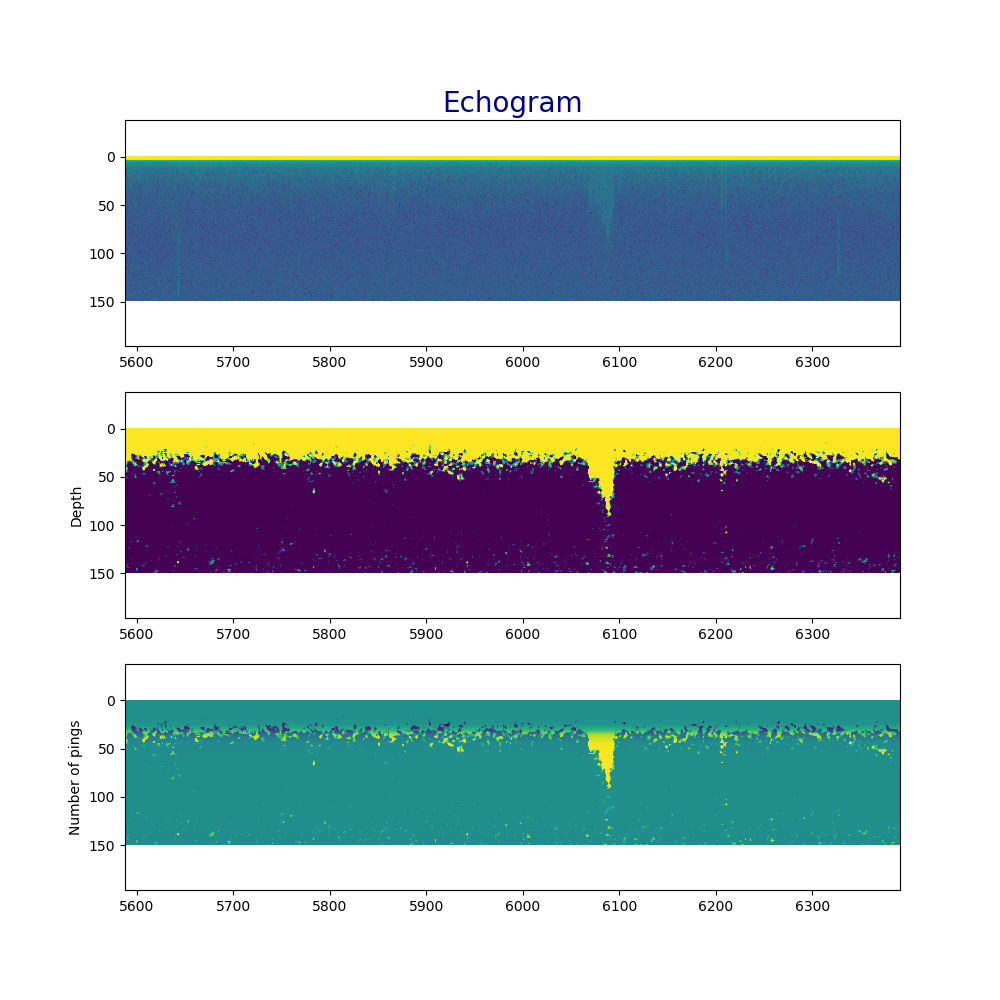

In [11]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(3,1,1)
ax1.imshow(data[0:150,:])
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(datafilt2[0:150,:])
plt.ylabel('Depth')
ax3 = plt.subplot(3,1,3, sharex=ax1, sharey=ax1)
ax3.imshow(data3[0:150,:])
plt.ylabel('Number of pings')
plt.show()

We then apply a Gaussian filter to the new echogram

In [12]:
from skimage.filters import gaussian
gauss_denoised = gaussian(data3,10)

### Visualisation of the results of the third filtering process

<IPython.core.display.Javascript object>


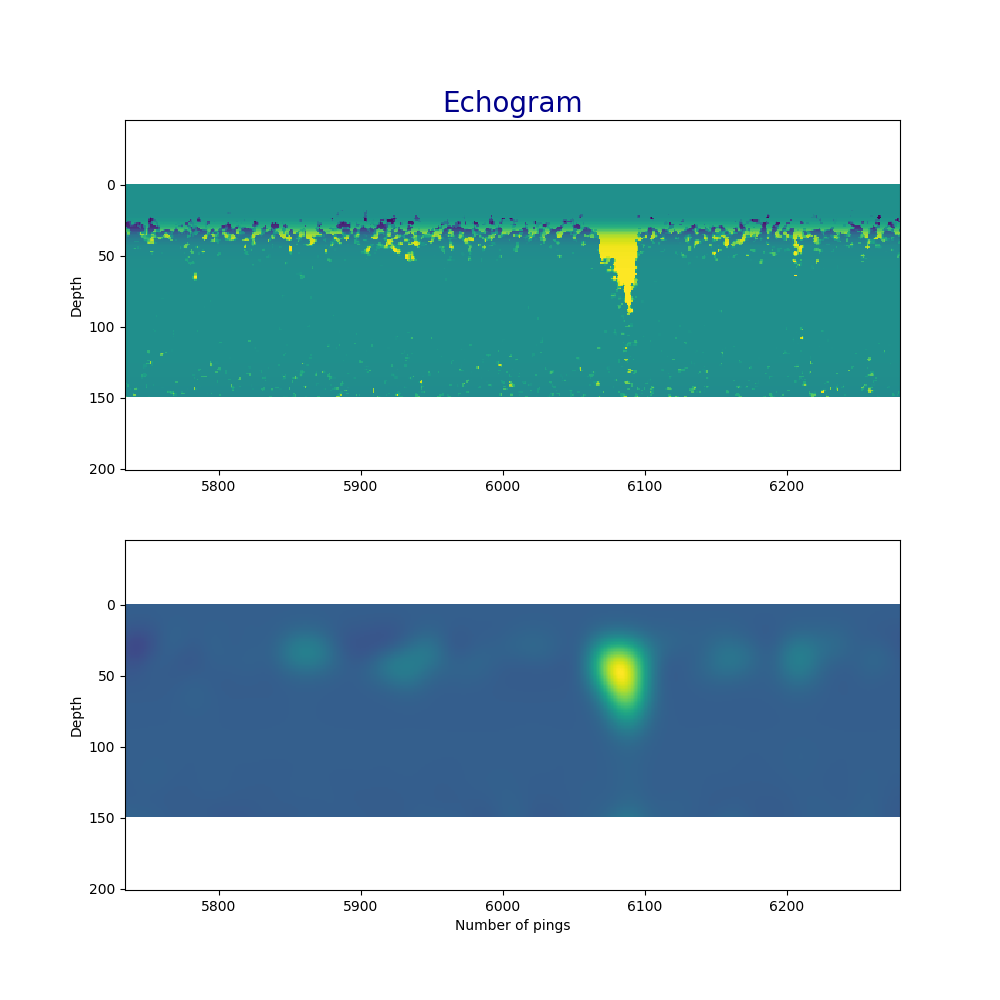

In [13]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(2,1,1)
ax1.imshow(data3[0:150,:])
plt.title('Echogram',fontsize=20, color="darkblue")
plt.ylabel('Depth')
ax2 = plt.subplot(2,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(gauss_denoised[0:150,:])
plt.ylabel('Depth')
plt.xlabel('Number of pings')
plt.show()

The krill detection function, which identify the columns with krill by summing up the intensity values of the whole column and removing the noise by substracting the mean again.

In [14]:
signaldata = gauss_denoised[0:150,:]
sumsignal = np.sum(signaldata,0)-np.mean(np.sum(signaldata,0))

### Visualisation of the results of the fourth filtering process

In [ ]:
#%matplotlib qt
#plt.plot(sumsignal)
#plt.show()

We then try to isolate the krill events in columns by using a binary component (using a signal threshold of 11dB)

In [15]:
binary_signal = sumsignal.copy()
threshold = 11
binary_signal[sumsignal<threshold] = 0
binary_signal[sumsignal>threshold] = 100

<IPython.core.display.Javascript object>


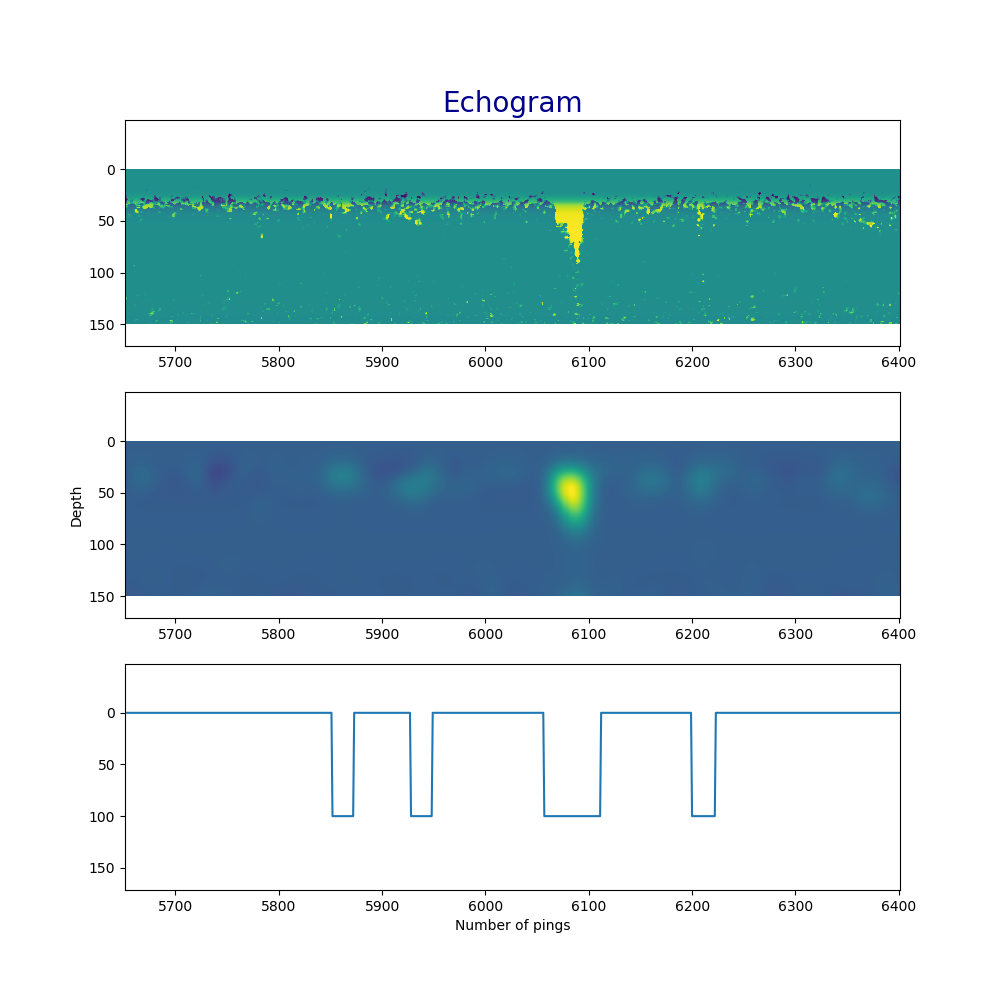

In [17]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.figure(figsize=(10,10))
ax1 = plt.subplot(3,1,1)
ax1.imshow(data3[0:150,:])
plt.title('Echogram',fontsize=20, color="darkblue")
ax2 = plt.subplot(3,1,2, sharex=ax1, sharey=ax1)
ax2.imshow(signaldata)
plt.ylabel('Depth')
ax3 = plt.subplot(3,1,3, sharex=ax1, sharey=ax1)
ax3.plot(binary_signal)
plt.xlabel('Number of pings')
plt.show()

## Map showing the location of the krill aggregations detected off the Antarctic peninsula

<img src="C:/Users/Camille Le Guen/Desktop/data jam days/krill.png">

This map has been made by Quentin Cavillier (quentin.cavillier@epfl.ch)using Javascript and Google map API

### Terms of use

Copyright (c) 2017 Benjamin Ricaud & Camille Le Guen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
